In [746]:
import pyodbc
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')

In [796]:
# Connect to the Database
cnxn = pyodbc.connect("Driver={SQL Server Native Client 11.0};"
                        "Server=wd02;"
                        "Database=FootPrint;"
                        "Trusted_Connection=yes;")

# QUERY 01: Operations

In [748]:
df = pd.read_sql_query("SELECT CONVERT(varchar,t.completedDateTime,100) Date, w.name warehouse, p.name project, oc.name operationCode, t.employee\
    FROM datex_footprint.Tasks t\
    JOIN datex_footprint.OperationCodes oc\
        ON oc.id = t.operationCodeId\
    JOIN datex_footprint.Warehouses w\
        ON w.id = t.warehouseId\
    JOIN datex_footprint.Projects p\
        ON p.id = t.projectId\
    WHERE (cast(t.completedDateTime as Date) = cast(getdate() as Date)) AND (t.employee != 'FootPrintService') AND (t.employee != 'Foot Print Service')\
    ORDER BY completedDateTime DESC", cnxn)

In [749]:
# Adding Hours
df['Hour'] = pd.to_datetime(df['Date']).dt.hour
df

,Date,warehouse,project,operationCode,employee,Hour
0,Mar 25 2022 4:13PM,10,ISDIN Corporation,Picking,Hugo Gonzales,16
1,Mar 25 2022 4:13PM,10,ISDIN Corporation,Picking,Andre Jocelin,16
2,Mar 25 2022 4:13PM,10,ISDIN Corporation,Picking,Hugo Gonzales,16
3,Mar 25 2022 4:13PM,10,ISDIN Corporation,Batch Move,Rita Geldres,16
4,Mar 25 2022 4:12PM,10,ISDIN Corporation,Batch Move,Rita Geldres,16
...,...,...,...,...,...,...
3134,Mar 25 2022 7:34AM,20,Alumier Labs Inc.,Picking,Wendy Medrano,7
3135,Mar 25 2022 7:33AM,20,Alumier Labs Inc.,Picking,Wendy Medrano,7
3136,Mar 25 2022 7:33AM,20,Alumier Labs Inc.,Picking,Wendy Medrano,7
3137,Mar 25 2022 7:33AM,20,Alumier Labs Inc.,Picking,Wendy Medrano,7


### Warehouse Activity

In [750]:
df_warehouse = df.groupby(['warehouse']).count()[['operationCode']]
df_warehouse.reset_index(inplace=True)
df_warehouse

,warehouse,operationCode
0,10,885
1,102,2
2,12,58
3,15,342
4,16,211
5,17,203
6,18,148
7,19,302
8,20,563
9,21,347


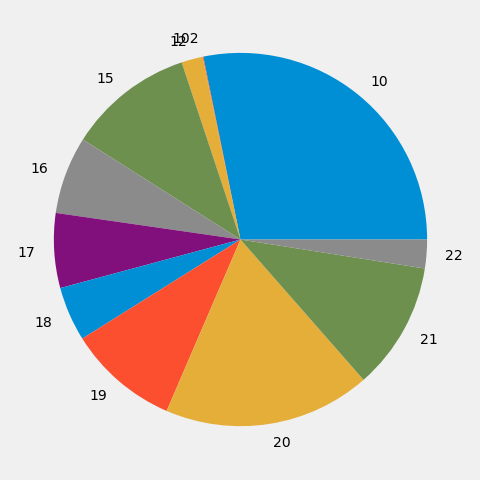

In [751]:
warehouse = df_warehouse['warehouse']
activity = df_warehouse['operationCode']

plt.subplots(figsize=(8,8))
plt.pie(activity, labels=warehouse)
plt.show()

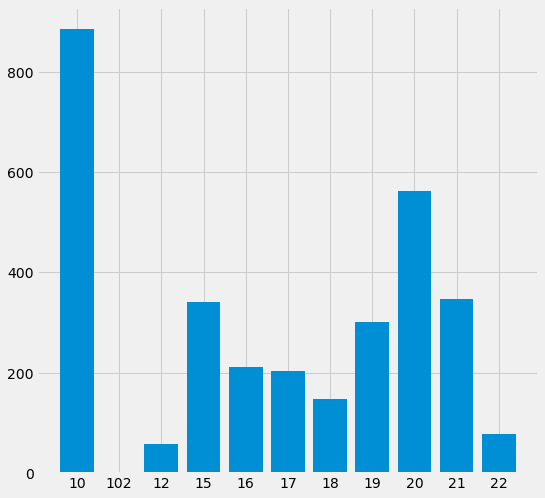

In [752]:
warehouse = df_warehouse['warehouse']
activity = df_warehouse['operationCode']

plt.subplots(figsize=(8,8))
plt.bar(warehouse, activity)
plt.show()

In [753]:
# Save Data in JSON format
df_warehouse_index = df_warehouse.set_index(['warehouse'])
df_warehouse_index.to_json('data/warehouse.json')
df_warehouse_index

,operationCode
warehouse,
10,885
102,2
12,58
15,342
16,211
17,203
18,148
19,302
20,563


### Operations type

In [754]:
df_operation = df.groupby(['operationCode']).count()[['project']]
df_operation.reset_index(inplace=True)
df_operation

,operationCode,project
0,Batch Move,258
1,Count,81
2,Create Inventory,5
3,DONE RECEIVING,18
4,DRIVER CHECK IN,30
5,Finished Receiving,4
6,Inventory Adjustment,36
7,Lot Status Change,82
8,Manual Batch Allocation,9
9,Manual Pick Allocation,243


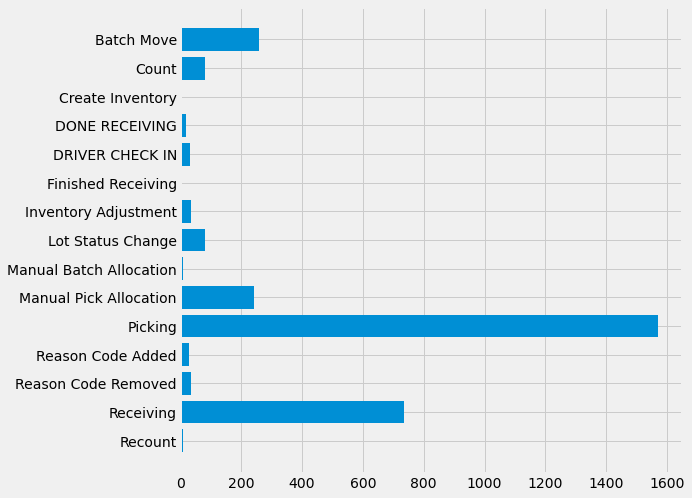

In [755]:
values = df_operation['project']
operation = df_operation['operationCode']

plt.subplots(figsize=(8,8))
plt.barh(operation, values)
plt.gca().invert_yaxis()
plt.show()

In [756]:
df_operation.rename(columns={"project": "Tasks"})
df_operation

,operationCode,project
0,Batch Move,258
1,Count,81
2,Create Inventory,5
3,DONE RECEIVING,18
4,DRIVER CHECK IN,30
5,Finished Receiving,4
6,Inventory Adjustment,36
7,Lot Status Change,82
8,Manual Batch Allocation,9
9,Manual Pick Allocation,243


In [757]:
# Save Data in JSON format
df_operation = df_operation.rename(columns={"project": "Tasks"})
df_operation_index = df_operation.set_index(['operationCode'])
df_operation_index.to_json('data/operations_type.json')
df_operation_index

,Tasks
operationCode,
Batch Move,258
Count,81
Create Inventory,5
DONE RECEIVING,18
DRIVER CHECK IN,30
Finished Receiving,4
Inventory Adjustment,36
Lot Status Change,82
Manual Batch Allocation,9


### Operations per Hour

In [758]:
df_hours = df.groupby(['Hour']).count()[['operationCode']]
df_hours.reset_index(inplace=True)
df_hours

,Hour,operationCode
0,7,51
1,8,186
2,9,319
3,10,636
4,11,434
5,12,401
6,13,369
7,14,329
8,15,369
9,16,45


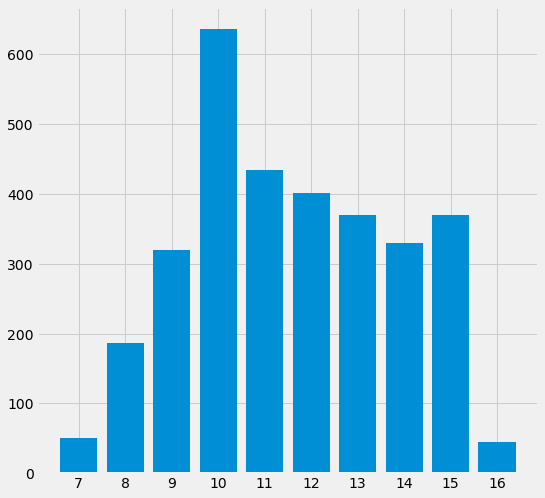

In [759]:
hour = df_hours['Hour']
activity = df_hours['operationCode']

plt.subplots(figsize=(8,8))
plt.bar(hour, activity)
plt.xticks(hour)
plt.show()

In [760]:
df_hours = df_hours.rename(columns={'operationCode': 'Operations'})
df_hours_index = df_hours.set_index(['Hour'])
df_hours_index.to_json('data/hours.json')
df_hours_index

,Operations
Hour,
7,51
8,186
9,319
10,636
11,434
12,401
13,369
14,329
15,369


# PICKING

In [761]:
# Filtered by Picking
df_picking = df[df['operationCode'] == 'Picking']

In [762]:
# Grouped by Employee and Hour
df_picking_grouped = df_picking.groupby(['employee', 'Hour']).count()[['operationCode']]
df_picking_grouped.reset_index(inplace=True)
df_picking_grouped.head()

,employee,Hour,operationCode
0,Aisha Cooper,8,1
1,Aisha Cooper,9,3
2,Aisha Cooper,10,2
3,Aisha Cooper,11,8
4,Aisha Cooper,12,1


In [763]:
# Pivot
df_picking_pivoted = df_picking_grouped.pivot(index='employee', columns='Hour', values='operationCode')
df_picking_pivoted = df_picking_pivoted.fillna(0)
df_picking_pivoted = df_picking_pivoted.rename_axis(None, axis=1)
#df_picking_pivoted.reset_index(inplace=True)

df_picking_pivoted

,7,8,9,10,11,12,13,14,15,16
employee,,,,,,,,,,
Aisha Cooper,0.0,1.0,3.0,2.0,8.0,1.0,4.0,4.0,0.0,0.0
Alejandro Aguirre,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,2.0
Andre Jocelin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,34.0,2.0
Angel Luna,0.0,1.0,24.0,0.0,0.0,2.0,0.0,6.0,0.0,0.0
Angela Pena,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0
Brad Bacchetti,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0
Edwin Perez,0.0,0.0,0.0,12.0,7.0,12.0,13.0,0.0,13.0,0.0
Ernest Ferguson,0.0,0.0,0.0,0.0,6.0,7.0,1.0,5.0,4.0,1.0
Frantz Laman,0.0,0.0,0.0,19.0,1.0,0.0,7.0,8.0,13.0,4.0


### Save in JSON File

In [764]:
# Save into JSON
pickers = df_picking_pivoted.T
pickers.to_json('data/pickers.json')
pickers

employee,Aisha Cooper,Alejandro Aguirre,Andre Jocelin,Angel Luna,Angela Pena,Brad Bacchetti,Edwin Perez,Ernest Ferguson,Frantz Laman,Gregory Watts,...,Sandra Vega,Sergio Piura,Shannon Williamson,Shawn Saunders,Thalia Rivera,Wendy Medrano,William Trevino Trevino,Yaima Castillo,Yulieth Aguirre,yudisel tubella
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,45.0,0.0,0.0,0.0,0.0
8,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,72.0,0.0,4.0,0.0,0.0
9,3.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,11.0,...,19.0,0.0,0.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0
10,2.0,0.0,0.0,0.0,26.0,0.0,12.0,0.0,19.0,2.0,...,28.0,0.0,0.0,0.0,1.0,8.0,2.0,0.0,1.0,0.0
11,8.0,0.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0,0.0,...,29.0,0.0,0.0,0.0,0.0,6.0,1.0,13.0,0.0,13.0
12,1.0,0.0,0.0,2.0,0.0,0.0,12.0,7.0,0.0,0.0,...,0.0,0.0,29.0,7.0,0.0,9.0,4.0,3.0,0.0,0.0
13,4.0,0.0,0.0,0.0,0.0,2.0,13.0,1.0,7.0,0.0,...,0.0,6.0,0.0,8.0,0.0,8.0,0.0,0.0,0.0,3.0
14,4.0,0.0,5.0,6.0,0.0,1.0,0.0,5.0,8.0,0.0,...,0.0,10.0,0.0,15.0,0.0,13.0,0.0,0.0,0.0,0.0
15,0.0,15.0,34.0,0.0,0.0,0.0,13.0,4.0,13.0,0.0,...,0.0,11.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
16,0.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


# Picking and W-10

In [765]:
# Filtered by Picking and Warehouse
df_picking_10 = df_picking[df_picking['warehouse'] == '10']
df_picking_10.head()

,Date,warehouse,project,operationCode,employee,Hour
0,Mar 25 2022 4:13PM,10,ISDIN Corporation,Picking,Hugo Gonzales,16
1,Mar 25 2022 4:13PM,10,ISDIN Corporation,Picking,Andre Jocelin,16
2,Mar 25 2022 4:13PM,10,ISDIN Corporation,Picking,Hugo Gonzales,16
19,Mar 25 2022 4:08PM,10,Bio-PRF,Picking,Frantz Laman,16
29,Mar 25 2022 4:06PM,10,ISDIN Corporation,Picking,Hugo Gonzales,16


In [766]:
# Grouped by Employee and Hour
df_picking_10_grouped = df_picking_10.groupby(['employee', 'Hour']).count()[['operationCode']]
df_picking_10_grouped.reset_index(inplace=True)
df_picking_10_grouped.head()

,employee,Hour,operationCode
0,Andre Jocelin,14,5
1,Andre Jocelin,15,34
2,Andre Jocelin,16,2
3,Frantz Laman,10,19
4,Frantz Laman,11,1


In [767]:
# Pivot
df_picking_10_pivoted = df_picking_10_grouped.pivot(index='employee', columns='Hour', values='operationCode')
df_picking_10_pivoted = df_picking_10_pivoted.fillna(0)
df_picking_10_pivoted = df_picking_10_pivoted.rename_axis(None, axis=1)
#df_picking_10_pivoted.reset_index(inplace=True)

df_picking_10_pivoted

,8,9,10,11,12,13,14,15,16
employee,,,,,,,,,
Andre Jocelin,0.0,0.0,0.0,0.0,0.0,0.0,5.0,34.0,2.0
Frantz Laman,0.0,0.0,19.0,1.0,0.0,7.0,8.0,13.0,4.0
Hugo Gonzales,0.0,17.0,35.0,45.0,0.0,0.0,11.0,36.0,7.0
Jackson Pierre,0.0,0.0,0.0,1.0,6.0,4.0,15.0,2.0,0.0
Liliana Puentes,0.0,0.0,0.0,0.0,0.0,4.0,4.0,9.0,0.0
Nelson Hurtado,5.0,8.0,5.0,9.0,10.0,0.0,0.0,1.0,0.0
Ronald Celis,0.0,4.0,6.0,3.0,8.0,6.0,1.0,8.0,0.0
Sergio Piura,0.0,0.0,0.0,0.0,0.0,6.0,10.0,11.0,0.0
Yulieth Aguirre,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### Save in JSON File

In [768]:
# Save into JSON
pickers_W10 = df_picking_10_pivoted.T
pickers_W10.to_json('data/pickers_w10.json')
pickers_W10

employee,Andre Jocelin,Frantz Laman,Hugo Gonzales,Jackson Pierre,Liliana Puentes,Nelson Hurtado,Ronald Celis,Sergio Piura,Yulieth Aguirre
8,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0
9,0.0,0.0,17.0,0.0,0.0,8.0,4.0,0.0,0.0
10,0.0,19.0,35.0,0.0,0.0,5.0,6.0,0.0,1.0
11,0.0,1.0,45.0,1.0,0.0,9.0,3.0,0.0,0.0
12,0.0,0.0,0.0,6.0,0.0,10.0,8.0,0.0,0.0
13,0.0,7.0,0.0,4.0,4.0,0.0,6.0,6.0,0.0
14,5.0,8.0,11.0,15.0,4.0,0.0,1.0,10.0,0.0
15,34.0,13.0,36.0,2.0,9.0,1.0,8.0,11.0,0.0
16,2.0,4.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0


In [769]:
df_picking_10_pivoted_T = df_picking_10_pivoted.T
df_picking_10_pivoted_T

employee,Andre Jocelin,Frantz Laman,Hugo Gonzales,Jackson Pierre,Liliana Puentes,Nelson Hurtado,Ronald Celis,Sergio Piura,Yulieth Aguirre
8,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0
9,0.0,0.0,17.0,0.0,0.0,8.0,4.0,0.0,0.0
10,0.0,19.0,35.0,0.0,0.0,5.0,6.0,0.0,1.0
11,0.0,1.0,45.0,1.0,0.0,9.0,3.0,0.0,0.0
12,0.0,0.0,0.0,6.0,0.0,10.0,8.0,0.0,0.0
13,0.0,7.0,0.0,4.0,4.0,0.0,6.0,6.0,0.0
14,5.0,8.0,11.0,15.0,4.0,0.0,1.0,10.0,0.0
15,34.0,13.0,36.0,2.0,9.0,1.0,8.0,11.0,0.0
16,2.0,4.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0


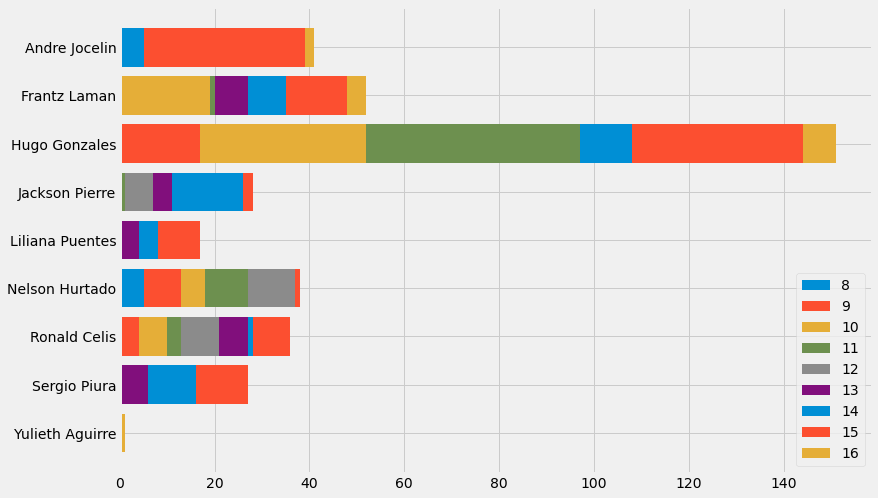

In [770]:
# Horizontal Chart
labels = df_picking_10_pivoted_T.columns
fig, ax = plt.subplots(figsize=(12,8))

left_hour = [0.] * df_picking_10_pivoted_T.shape[1]

for i in df_picking_10_pivoted_T.index:
    ax.barh(labels, df_picking_10_pivoted_T.loc[i].values, left = left_hour)
    left_hour += df_picking_10_pivoted_T.loc[i].values

ax.legend(df_picking_10_pivoted_T.index)
plt.gca().invert_yaxis()
plt.show()

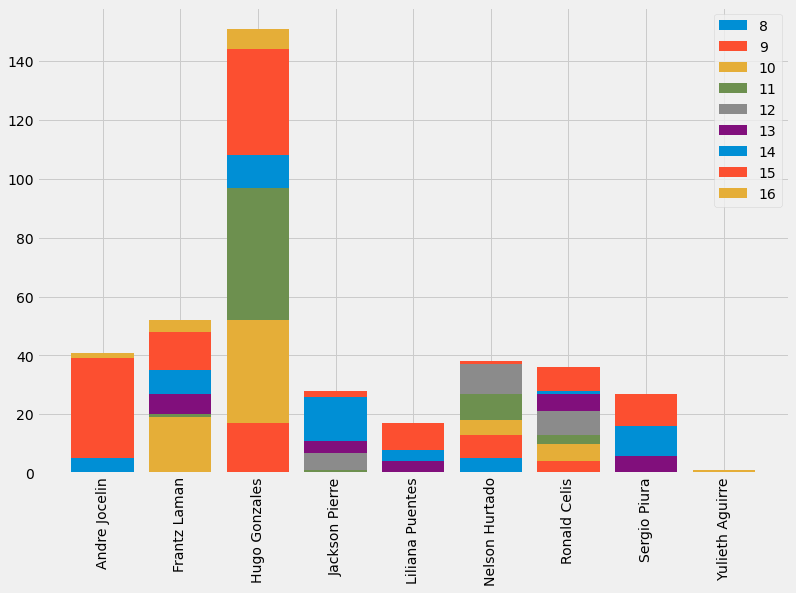

In [771]:
# Vertical Chart
labels = df_picking_10_pivoted_T.columns
fig, ax = plt.subplots(figsize=(12,8))

bottom_hour = [0.] * df_picking_10_pivoted_T.shape[1]

for i in df_picking_10_pivoted_T.index:
    ax.bar(labels, df_picking_10_pivoted_T.loc[i].values, bottom = bottom_hour)
    bottom_hour += df_picking_10_pivoted_T.loc[i].values

ax.legend(df_picking_10_pivoted_T.index)

plt.xticks(rotation=90)
plt.show()

# Picking and W-20

In [772]:
# Filtered by Picking and Warehouse
df_picking_20 = df_picking[df_picking['warehouse'] == '20']
df_picking_20.head()

,Date,warehouse,project,operationCode,employee,Hour
22,Mar 25 2022 4:07PM,20,Sartorius Stedim North America,Picking,Ernest Ferguson,16
49,Mar 25 2022 3:58PM,20,Sartorius Stedim North America,Picking,Ernest Ferguson,15
69,Mar 25 2022 3:55PM,20,Sartorius Stedim North America,Picking,Ernest Ferguson,15
85,Mar 25 2022 3:53PM,20,Reliable 1 Laboratories LLC,Picking,Shawn Saunders,15
105,Mar 25 2022 3:52PM,20,Reliable 1 Laboratories LLC,Picking,Shawn Saunders,15


In [773]:
# Grouped by Employee and Hour
df_picking_20_grouped = df_picking_20.groupby(['employee', 'Hour']).count()[['operationCode']]
df_picking_20_grouped.reset_index(inplace=True)
df_picking_20_grouped.head()

,employee,Hour,operationCode
0,Aisha Cooper,8,1
1,Aisha Cooper,9,3
2,Aisha Cooper,10,2
3,Aisha Cooper,11,8
4,Aisha Cooper,12,1


In [774]:
# Pivot
df_picking_20_pivoted = df_picking_20_grouped.pivot(index='employee', columns='Hour', values='operationCode')
df_picking_20_pivoted = df_picking_20_pivoted.fillna(0)
df_picking_20_pivoted = df_picking_20_pivoted.rename_axis(None, axis=1)
#df_picking_10_pivoted.reset_index(inplace=True)

df_picking_20_pivoted

,7,8,9,10,11,12,13,14,15,16
employee,,,,,,,,,,
Aisha Cooper,0.0,1.0,3.0,2.0,8.0,1.0,4.0,4.0,0.0,0.0
Ernest Ferguson,0.0,0.0,0.0,0.0,6.0,7.0,1.0,5.0,4.0,1.0
Gregory Watts,0.0,4.0,11.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
Maria Ramos,0.0,0.0,0.0,0.0,0.0,25.0,21.0,55.0,0.0,0.0
Micah Powers,0.0,0.0,3.0,6.0,0.0,0.0,0.0,1.0,0.0,0.0
Reggie Bracken,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Shawn Saunders,0.0,0.0,0.0,0.0,0.0,7.0,8.0,15.0,5.0,0.0
Thalia Rivera,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Wendy Medrano,45.0,72.0,60.0,8.0,6.0,9.0,8.0,13.0,0.0,0.0


### Save in JSON File

In [775]:
pickers_W20 = df_picking_20_pivoted.T
pickers_W20.to_json('data/pickers_w20.json')
pickers_W20

employee,Aisha Cooper,Ernest Ferguson,Gregory Watts,Maria Ramos,Micah Powers,Reggie Bracken,Shawn Saunders,Thalia Rivera,Wendy Medrano
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0
8,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,72.0
9,3.0,0.0,11.0,0.0,3.0,3.0,0.0,0.0,60.0
10,2.0,0.0,2.0,0.0,6.0,0.0,0.0,1.0,8.0
11,8.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
12,1.0,7.0,0.0,25.0,0.0,0.0,7.0,0.0,9.0
13,4.0,1.0,0.0,21.0,0.0,0.0,8.0,0.0,8.0
14,4.0,5.0,0.0,55.0,1.0,0.0,15.0,0.0,13.0
15,0.0,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0
16,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [776]:
df_picking_20_pivoted_T = df_picking_20_pivoted.T
df_picking_20_pivoted_T

employee,Aisha Cooper,Ernest Ferguson,Gregory Watts,Maria Ramos,Micah Powers,Reggie Bracken,Shawn Saunders,Thalia Rivera,Wendy Medrano
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0
8,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,72.0
9,3.0,0.0,11.0,0.0,3.0,3.0,0.0,0.0,60.0
10,2.0,0.0,2.0,0.0,6.0,0.0,0.0,1.0,8.0
11,8.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
12,1.0,7.0,0.0,25.0,0.0,0.0,7.0,0.0,9.0
13,4.0,1.0,0.0,21.0,0.0,0.0,8.0,0.0,8.0
14,4.0,5.0,0.0,55.0,1.0,0.0,15.0,0.0,13.0
15,0.0,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0
16,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


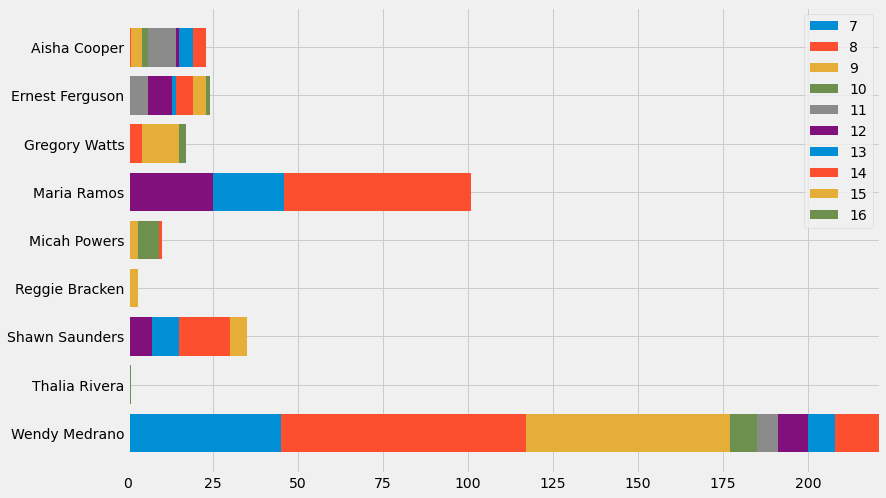

In [777]:
# Horizontal Chart
labels = df_picking_20_pivoted_T.columns
fig, ax = plt.subplots(figsize=(12,8))

left_hour = [0.] * df_picking_20_pivoted_T.shape[1]

for i in df_picking_20_pivoted_T.index:
    ax.barh(labels, df_picking_20_pivoted_T.loc[i].values, left = left_hour)
    left_hour += df_picking_20_pivoted_T.loc[i].values

ax.legend(df_picking_20_pivoted_T.index)
plt.gca().invert_yaxis()
plt.show()

In [778]:
df_picking_20_pivoted_T.index

Int64Index([7, 8, 9, 10, 11, 12, 13, 14, 15, 16], dtype='int64')

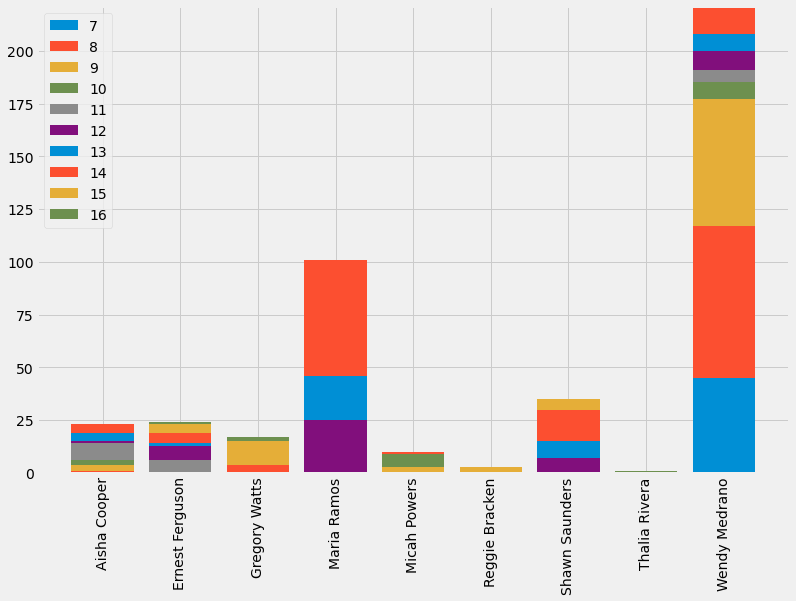

In [779]:
# Vertical Chart
labels = df_picking_20_pivoted_T.columns
fig, ax = plt.subplots(figsize=(12,8))

bottom_hour = [0.] * df_picking_20_pivoted_T.shape[1]

for i in df_picking_20_pivoted_T.index:
    ax.bar(labels, df_picking_20_pivoted_T.loc[i].values, bottom = bottom_hour)
    bottom_hour += df_picking_20_pivoted_T.loc[i].values

ax.legend(df_picking_20_pivoted_T.index)

plt.xticks(rotation=90)
plt.show()

# QUERY 02: Open Outbounds

In [797]:
df_02 = pd.read_sql_query("SELECT DISTINCT w.name warehouse, p.name project, s.lookupCode shipment_number, s.createdSysDateTime\
    FROM datex_footprint.shipments s\
    LEFT JOIN datex_footprint.ShipmentOrderLookup sol\
        on sol.shipmentId = s.id\
    LEFT JOIN datex_footprint.orders o\
        on o.id = sol.orderId\
    LEFT JOIN datex_footprint.Projects p\
        on p.id = o.projectId\
    LEFT JOIN datex_footprint.warehouses w\
        on w.id = isnull(s.actualWarehouseId, s.expectedWarehouseId)\
    WHERE s.statusId in (1, 2, 4) and s.typeId = 2\
    ORDER BY createdSysDateTime", cnxn)

In [798]:
df_02

,warehouse,project,shipment_number,createdSysDateTime
0,17,"TherapeuticsMD, Inc.",489832,2017-07-26 09:09:09.197
1,19,"Novadoz Pharmaceuticals, LLC",1901075,2019-09-30 10:50:10.143
2,10,"Chadwick Pharmaceuticals, Inc.",2167054,2019-11-14 16:36:44.793
3,10,Eywa Pharma Inc.,2475492,2020-01-22 13:20:13.063
4,10,Eywa Pharma Inc.,2475493,2020-01-22 13:20:13.447
...,...,...,...,...
7176,22,"NBTY Global, Inc.",609251,2022-03-25 16:05:02.743
7177,10,ISDIN Corporation,0085548230,2022-03-25 16:05:10.790
7178,22,"NBTY Global, Inc.",609252,2022-03-25 16:10:02.453
7179,20,Sartorius Stedim North America,SSNA-2173510794,2022-03-25 16:11:41.847


In [799]:
df_02.dtypes

warehouse                     object
project                       object
shipment_number               object
createdSysDateTime    datetime64[ns]
dtype: object

In [800]:
df_02['age_order'] = pd.Timestamp.now() - df_02['createdSysDateTime']
df_02

,warehouse,project,shipment_number,createdSysDateTime,age_order
0,17,"TherapeuticsMD, Inc.",489832,2017-07-26 09:09:09.197,1703 days 07:10:45.798481
1,19,"Novadoz Pharmaceuticals, LLC",1901075,2019-09-30 10:50:10.143,907 days 05:29:44.852481
2,10,"Chadwick Pharmaceuticals, Inc.",2167054,2019-11-14 16:36:44.793,861 days 23:43:10.202481
3,10,Eywa Pharma Inc.,2475492,2020-01-22 13:20:13.063,793 days 02:59:41.932481
4,10,Eywa Pharma Inc.,2475493,2020-01-22 13:20:13.447,793 days 02:59:41.548481
...,...,...,...,...,...
7176,22,"NBTY Global, Inc.",609251,2022-03-25 16:05:02.743,0 days 00:14:52.252481
7177,10,ISDIN Corporation,0085548230,2022-03-25 16:05:10.790,0 days 00:14:44.205481
7178,22,"NBTY Global, Inc.",609252,2022-03-25 16:10:02.453,0 days 00:09:52.542481
7179,20,Sartorius Stedim North America,SSNA-2173510794,2022-03-25 16:11:41.847,0 days 00:08:13.148481


In [801]:
df_02.dtypes

warehouse                      object
project                        object
shipment_number                object
createdSysDateTime     datetime64[ns]
age_order             timedelta64[ns]
dtype: object

In [802]:
df_02['age_order_days'] = df_02['age_order'].dt.components['days']
df_02['age_order_hours'] = df_02['age_order'].dt.components['hours']
df_02

,warehouse,project,shipment_number,createdSysDateTime,age_order,age_order_days,age_order_hours
0,17,"TherapeuticsMD, Inc.",489832,2017-07-26 09:09:09.197,1703 days 07:10:45.798481,1703,7
1,19,"Novadoz Pharmaceuticals, LLC",1901075,2019-09-30 10:50:10.143,907 days 05:29:44.852481,907,5
2,10,"Chadwick Pharmaceuticals, Inc.",2167054,2019-11-14 16:36:44.793,861 days 23:43:10.202481,861,23
3,10,Eywa Pharma Inc.,2475492,2020-01-22 13:20:13.063,793 days 02:59:41.932481,793,2
4,10,Eywa Pharma Inc.,2475493,2020-01-22 13:20:13.447,793 days 02:59:41.548481,793,2
...,...,...,...,...,...,...,...
7176,22,"NBTY Global, Inc.",609251,2022-03-25 16:05:02.743,0 days 00:14:52.252481,0,0
7177,10,ISDIN Corporation,0085548230,2022-03-25 16:05:10.790,0 days 00:14:44.205481,0,0
7178,22,"NBTY Global, Inc.",609252,2022-03-25 16:10:02.453,0 days 00:09:52.542481,0,0
7179,20,Sartorius Stedim North America,SSNA-2173510794,2022-03-25 16:11:41.847,0 days 00:08:13.148481,0,0


In [803]:
bins =[-1,1,2,3,7,30,60, 90,365, 730,10000]
bin_names = ['24 Hours', '48 Hours', '72 Hours', '1 Week', '1 Month', '2 Months', '3 Months', '1 Year', '2 Years', 'More than 2 years']

df_02['age_group'] = pd.cut(df_02['age_order_days'], bins, labels=bin_names)

In [804]:
df_02_grouped = df_02.groupby(['age_group'])[['project']].count()

In [805]:
df_02_grouped = df_02_grouped.rename(columns={'project': 'orders'})

In [806]:
df_02_grouped

,orders
age_group,
24 Hours,761
48 Hours,245
72 Hours,246
1 Week,404
1 Month,1065
2 Months,651
3 Months,581
1 Year,2178
2 Years,995


### Save in JSON File

In [807]:
open_outbounds = df_02_grouped
open_outbounds.to_json('data/open_outbounds.json')
open_outbounds

,orders
age_group,
24 Hours,761
48 Hours,245
72 Hours,246
1 Week,404
1 Month,1065
2 Months,651
3 Months,581
1 Year,2178
2 Years,995


<AxesSubplot:ylabel='age_group'>

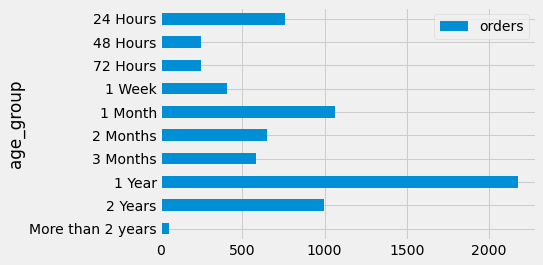

In [808]:
df_02_grouped = df_02_grouped.iloc[::-1]
df_02_grouped.plot.barh()

In [809]:
# Close connection
cnxn.close()